Versionskontrollsysteme sind eine unglaubliche Informationsquelle um Softwaresysteme und deren Entwicklung zu analysieren. Allein durch simple Informationen über welcher Autor hat wann was geändert lassen sich einige sehr interessante Dinge herausstellen.

In diesem Artikel sehen wir uns an, was wir mit einem sog. _git blame log_ alles herausfinden können. Ein git blame log enthält Informationen darüber, welcher Autor in welcher Datei welche Zeilenänderung durchgeführt hat. Nehmen wir hier nur alle als zuletzt durchgeführte Zeilenänderungen je Quellcodedatei, können wir darüber potenziell abschätzen, wer noch etwas über eine Zeile wissen könnte. Darüber können wir berechnen, wer noch etwas übe reine komplette Datei sowie einer Komponente (was das auch immer sein möge) wissen könnte.

Als Basis des ganzen ist jedoch einiges an Vorarbeit notwendig. Wir brauchen ein git blame für jede Datei unseres Softwaresystems.

In [1]:
import pandas as pd

log = pd.read_csv("../../../software-data/projects/linux/linux_blame_log.csv.gz")
log.head()


,path,author,timestamp,line
0,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,1448528085000000000,1
1,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,1448528085000000000,2
2,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,1448528085000000000,3
3,drivers/scsi/bfa/bfad_drv.h,Jing Huang,1253753175000000000,4
4,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,1448528085000000000,5


In [2]:
log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5665947 entries, 0 to 5665946
Data columns (total 4 columns):
path         object
author       object
timestamp    int64
line         int64
dtypes: int64(2), object(2)
memory usage: 172.9+ MB


In [3]:
top10 = log['author'].value_counts().head(10)
top10

Linus Torvalds           838200
Hans Verkuil             118432
Mauro Carvalho Chehab    102107
Michael Chan              53945
Mike Marciniszyn          44843
Ralph Campbell            42453
Nicholas Bellinger        41823
Laurent Pinchart          40438
Antti Palosaari           40390
Alexander Duyck           39307
Name: author, dtype: int64

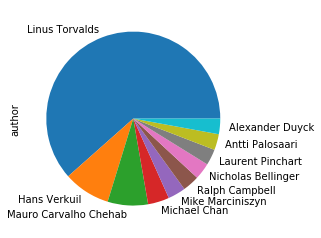

In [4]:
%matplotlib inline
top10.plot.pie();

# No-Go Areas

In [5]:
log['timestamp'] = pd.to_datetime(log['timestamp'])
log.head()

,path,author,timestamp,line
0,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,1
1,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,2
2,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,3
3,drivers/scsi/bfa/bfad_drv.h,Jing Huang,2009-09-24 00:46:15,4
4,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,5


In [6]:
log['age'] = pd.Timestamp("today") - log['timestamp']
log.head()

,path,author,timestamp,line,age
0,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,1,1097 days 01:02:04.626548
1,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,2,1097 days 01:02:04.626548
2,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,3,1097 days 01:02:04.626548
3,drivers/scsi/bfa/bfad_drv.h,Jing Huang,2009-09-24 00:46:15,4,3351 days 09:10:34.626548
4,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,5,1097 days 01:02:04.626548


In [7]:
log['component'] = log['path'].str.split("/").str[:2].str.join(":")
log.head()

,path,author,timestamp,line,age,component
0,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,1,1097 days 01:02:04.626548,drivers:scsi
1,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,2,1097 days 01:02:04.626548,drivers:scsi
2,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,3,1097 days 01:02:04.626548,drivers:scsi
3,drivers/scsi/bfa/bfad_drv.h,Jing Huang,2009-09-24 00:46:15,4,3351 days 09:10:34.626548,drivers:scsi
4,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,5,1097 days 01:02:04.626548,drivers:scsi


In [8]:
age_per_component = log.groupby('component')['age'].min().sort_values()
age_per_component.head()

component
drivers:scsi   229 days 16:30:40.626548
drivers:i2c    229 days 17:51:15.626548
drivers:net    229 days 18:06:31.626548
drivers:of     230 days 10:25:33.626548
drivers:pci    230 days 14:12:28.626548
Name: age, dtype: timedelta64[ns]

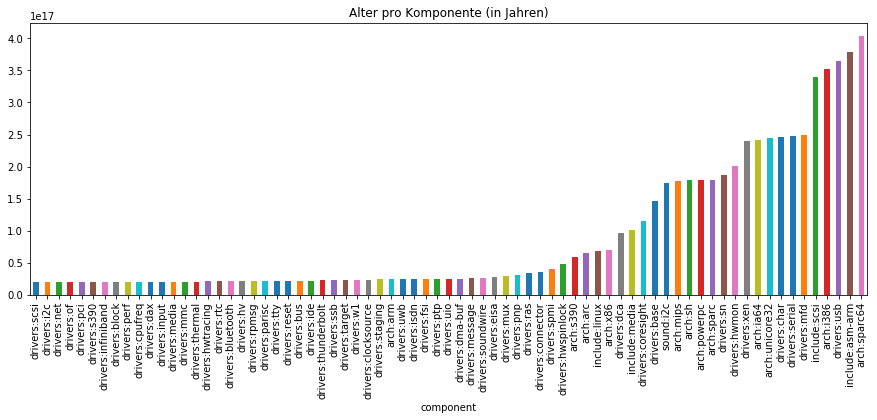

In [9]:
age_per_component.plot.bar(
    title="Alter pro Komponente (in Jahren)",
    figsize=[15,5]);

# Wissensinseln
## Bewertung des vorhandenen Wissens
...anhand der zuletzt geänderten Quellcodezeilen

## Gruppieren mit minimalen Zeitdauer und Zeilenanzahl
=> Jüngste Änderung und Anzahl geänderter Zeilen pro Datei und Autor 

In [10]:
knowledge = log.groupby(
    ['path', 'author']).agg(
        {'timestamp':'min', 'line':'count'}
    )
knowledge.head()

timestamp  line
path                            author                                       
arch/arc/kernel/time.c          Anna-Maria Gleixner 2016-07-13 17:17:07    13
                                Daniel Lezcano      2016-06-15 12:50:12    31
                                Noam Camus          2016-01-01 10:18:49    18
                                Vineet Gupta        2013-01-18 09:42:18   243
                                Viresh Kumar        2015-07-16 11:26:14     6

## Wissensanteile berechnen
=> Prozentualer Anteil der zuletzt geänderten Zeilen pro Datei und Autor

In [13]:
knowledge['all'] = knowledge.groupby('path')['line'].transform('sum')
knowledge['knowing'] = knowledge['line'] / knowledge['all']
knowledge.head()

timestamp  line  \
path                            author                                          
arch/arc/kernel/time.c          Anna-Maria Gleixner 2016-07-13 17:17:07    13   
                                Daniel Lezcano      2016-06-15 12:50:12    31   
                                Noam Camus          2016-01-01 10:18:49    18   
                                Vineet Gupta        2013-01-18 09:42:18   243   
                                Viresh Kumar        2015-07-16 11:26:14     6   

                                                     all     ratio   knowing  
path                            author                                        
arch/arc/kernel/time.c          Anna-Maria Gleixner  311  0.041801  0.041801  
                                Daniel Lezcano       311  0.099678  0.099678  
                                Noam Camus           311  0.057878  0.057878  
                                Vineet Gupta         311  0.781350  0.781350  
                                Viresh Kumar         311  0.019293  0.019293

### Maximales Wissen pro Datei identifizieren
=> Hauptautor pro Datei

In [14]:
max_knowledge_per_file = knowledge.groupby(['path'])['knowing'].transform(max)
knowledge_carriers = knowledge[knowledge['knowing'] == max_knowledge_per_file]
knowledge_carriers = knowledge_carriers.reset_index(level=1)
knowledge_carriers.head()

,author,timestamp,line,all,ratio,knowing
path,,,,,,
arch/arc/kernel/time.c,Vineet Gupta,2013-01-18 09:42:18,243,311,0.781350,0.781350
arch/arm/common/timer-sp.c,Rob Herring,2011-12-12 21:29:08,111,169,0.656805,0.656805
arch/arm/include/asm/hardware/arm_timer.h,Russell King,2010-01-16 15:07:08,24,29,0.827586,0.827586
arch/arm/kernel/perf_event.c,Jamie Iles,2010-02-02 19:25:44,176,523,0.336520,0.336520
arch/arm/mach-at91/at91rm9200_time.c,David Brownell,2007-07-31 00:41:26,81,95,0.852632,0.852632


### Visualisierung erstellen
=> Export in D3 Visualisierung "Zoomable Circle Packing"

In [17]:
from ausi import d3

d3.create_json_for_zoomable_circle_packing(
    knowledge_carriers.reset_index(),
    'author',
    'author',
    'path',
    '/',
    'all',
    'knowing',
    'linux_circle_packing'
)

JSON file produced in 'C:\dev\repos\software-analytics\demos\20181121_GraphDB_Berlin\linux_circle_packing.json'
HTML file produced in 'C:\dev\repos\software-analytics\demos\20181121_GraphDB_Berlin\linux_circle_packing.html'
